### Ultimate Technologies, Inc. Take Home Challenge ###
Logan Schmitt
11/29/2023

In [1]:
import pandas as pd
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# EDA #
### Task ###
Aggregate the login information in 15 minute intervals and explore the underlying patterns of demand. Illustrate important features like daily cycles and report data quality issues.

In [2]:
df = pd.read_json('logins.json')

In [3]:
df.sort_values(by = 'login_time', ascending = True).head()

login_time
6 1970-01-01 20:12:16
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
3 1970-01-01 20:16:36
2 1970-01-01 20:16:37

In [4]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
df.isna().sum()

login_time    0
dtype: int64

### Data Quality ###
So far, there are no null values or type issues. Let's visualize the data and see if there are gaps or outliers.

### Intervals ###
Split the data into intervals of 15 minutes

In [6]:
interval_df = (df
               .set_index('login_time')
               .resample('15T')
               .size()
               .reset_index(drop = False)
               .assign(day = ( lambda x: x['login_time'].dt.day_name()))
               .assign(date = (lambda x: x['login_time'].dt.date))
               .assign(time = (lambda x: x['login_time'].dt.strftime('%H:%M:%S')))
               .rename(columns = {0: 'num_logins', 'login_time': 'login_window'})
               .reindex(columns = ['day', 'date', 'time', 'login_window', 'num_logins'])
              )

interval_df.head()

day        date      time        login_window  num_logins
0  Thursday  1970-01-01  20:00:00 1970-01-01 20:00:00           2
1  Thursday  1970-01-01  20:15:00 1970-01-01 20:15:00           6
2  Thursday  1970-01-01  20:30:00 1970-01-01 20:30:00           9
3  Thursday  1970-01-01  20:45:00 1970-01-01 20:45:00           7
4  Thursday  1970-01-01  21:00:00 1970-01-01 21:00:00           1

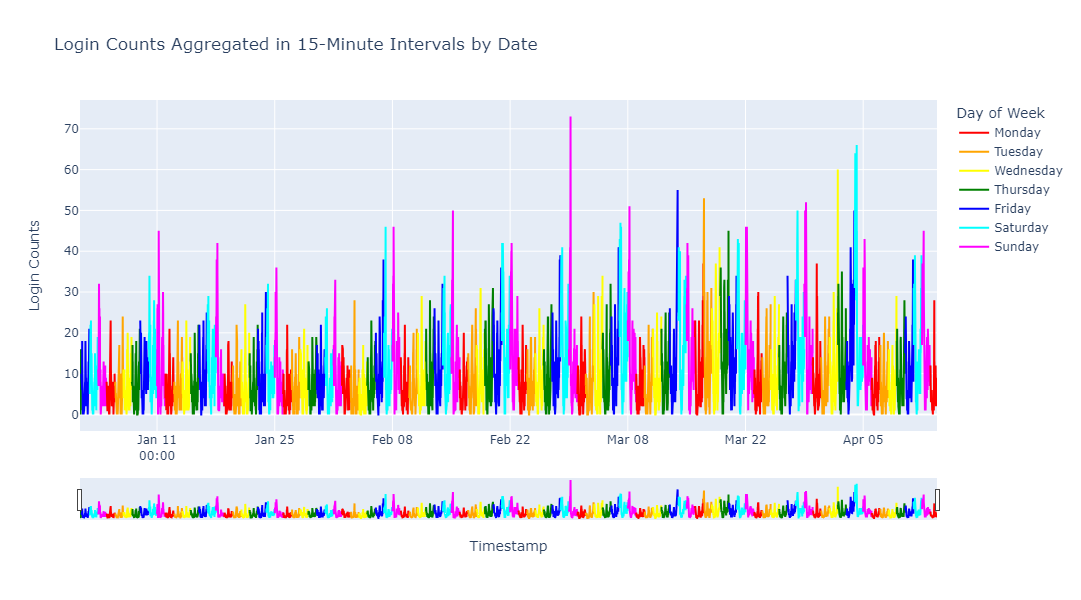

In [7]:
# Create a Plotly figure
fig = go.Figure()

# Legend color map
color_map = {
    'Monday': 'red',
    'Tuesday': 'orange',
    'Wednesday': 'yellow',
    'Thursday': 'green',
    'Friday': 'blue',
    'Saturday': 'cyan',
    'Sunday': 'magenta'}

# Don't add traces to legend by default
show_legend = 0

# Add a trace for each date
for date in interval_df['date'].unique():
    date_data = interval_df.loc[interval_df['date'] == date]
    weekday = date_data['day'].iloc[0]
    
    # Increment the week counter on Monday
    if weekday == 'Monday':
        show_legend += 1
    else:
        pass
    
    # Avoid repeating days in the legend and make it start on Monday
    if show_legend == 1:
        fig.add_scatter(x = date_data['login_window'],
                        y = date_data['num_logins'],
                        mode = 'lines',
                        name = f'{weekday}',
                        line = dict(color = color_map[weekday]),
                        showlegend = True)      

    else:
        fig.add_scatter(x = date_data['login_window'],
                        y = date_data['num_logins'],
                        mode = 'lines',
                        name = f'{weekday}',
                        line = dict(color = color_map[weekday]),
                        showlegend = False
                       )
        
# Update layout to add rangeslider
fig.update_layout(
    autosize = True,
    #width = 800,
    height = 600,
    title = 'Login Counts Aggregated in 15-Minute Intervals by Date',
    legend_title = 'Day of Week',
    xaxis_title = 'Timestamp',
    yaxis_title = 'Login Counts',
    xaxis_rangeslider_visible = True,
    xaxis = dict(
        tickformat = "%b %d\n%H:%M",  # Formatting date and time for better readability
        rangeslider = dict(
            visible = True,
            thickness = 0.1)
        )
)

fig.show()

### Interval Visualization ###
Use the interactive toolbar to explore the graph in greater detail.

There don't seem to be any missing days or clear outliers. We can see that Sundays often see the busiest login window of the week with a login spike between 4am and 5am. Saturdays also seem to feature early morning login spikes. There appears to be a trend of growth through the week, with Mondays having the lowest activity.

### Daily Trend ###
Let's see if certain days have more logins than others in general.

In [8]:
daily_logins = (interval_df
           .copy()
           .groupby(['date', 'day'])
           .agg({'num_logins': 'sum'})
           .reset_index(drop = False)
          )

daily_logins.head()

date       day  num_logins
0  1970-01-01  Thursday         112
1  1970-01-02    Friday         681
2  1970-01-03  Saturday         793
3  1970-01-04    Sunday         788
4  1970-01-05    Monday         459

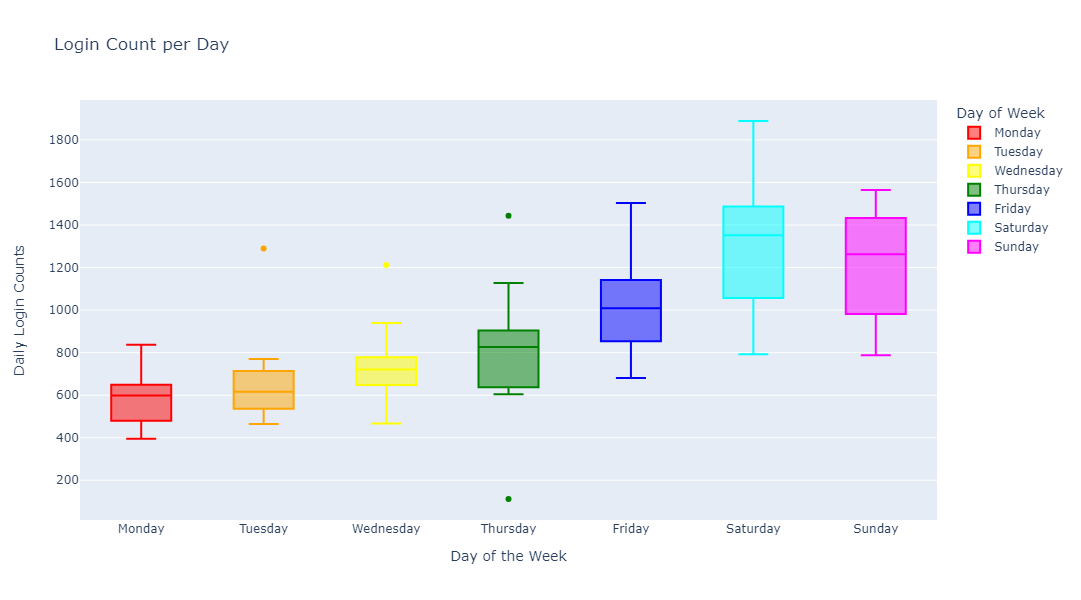

In [9]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_logins['day'] = pd.Categorical(daily_logins['day'], categories=ordered_days, ordered=True)
daily_logins = daily_logins.sort_values('day')

# Create a bar graph with Plotly
fig = go.Figure()

for day in ordered_days:
    fig.add_trace(go.Box(x = daily_logins[daily_logins['day'] == day]['day'],
                         y = daily_logins.loc[daily_logins['day'] == day]['num_logins'],
                         marker_color = color_map[day],
                         name = f'{day}'
                      )
            )

fig.update_layout(
    autosize = True,
    height = 600,
    title = 'Login Count per Day',
    xaxis_title = 'Day of the Week',
    yaxis_title = 'Daily Login Counts',
    legend_title = 'Day of Week'
)

fig.show()

### Daily Trend ###
There indeed appears to be a trend of increasing logins through the week, peaking with Saturday. While Sunday does see a large volume of early morning logins, Saturday has a greater volume overall. Let's combine this result with the previous graph and break down each day's results into 6-hour segments to get a better picture of when the logins tend to happen each day.

In [10]:
# Defining segments of the day
def categorize_time(time):
    ''' (datetime object) -> str
    Categorizes the hour of day.
    Morning is between 4am and 10am. Midday is from 10am until 4pm. 
    Evening is from 4pm until 10pm. Night is from 10pm until 4am.
    '''
    if time.hour > 22:
        return 'Night'
    elif time.hour > 16:
        return 'Evening'
    elif time.hour > 10:
        return 'Midday'
    elif time.hour > 4:
        return 'Morning'
    else:
        return 'Night'

daily_chunk_df = (df
                  .set_index('login_time')
                  .resample('360T')
                  .size()
                  .reset_index(drop = False)
                  .assign(day = (lambda x: x['login_time'].dt.day_name()),
                          date = (lambda x: x['login_time'].dt.date),
                          chunk = (lambda x: x['login_time'].apply(categorize_time))
                         )
                  .rename(columns = {0: 'num_logins', 'login_time': 'login_window'})
                  .reindex(columns = ['day', 'chunk', 'num_logins'])
                  .groupby(['day', 'chunk'])
                  .agg({'num_logins': 'median'})
                  .reset_index(drop = False)
                )

daily_chunk_df.head()

day    chunk  num_logins
0  Friday  Evening       423.0
1  Friday   Midday       190.0
2  Friday  Morning       138.0
3  Friday    Night       255.0
4  Monday  Evening       206.0

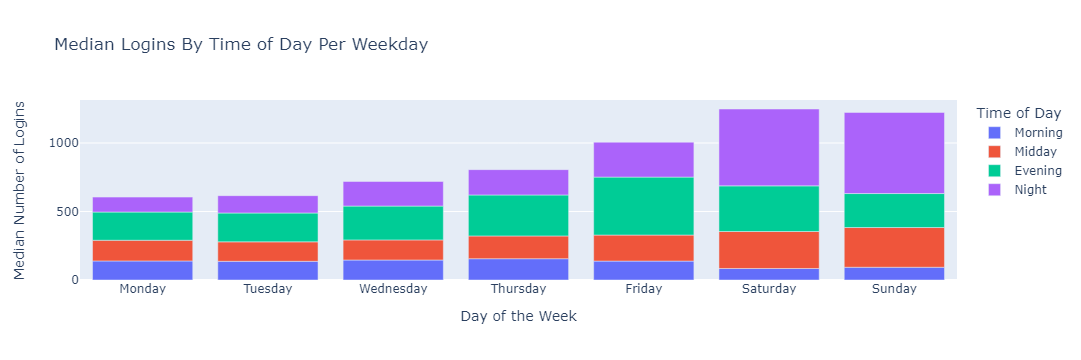

In [11]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_chunk_df['day'] = pd.Categorical(daily_chunk_df['day'], categories=ordered_days, ordered=True)

# Define custom order for chunks
ordered_chunks = ['Morning', 'Midday', 'Evening', 'Night']
daily_chunk_df['chunk'] = pd.Categorical(daily_chunk_df['chunk'], categories=ordered_chunks, ordered=True)

# Sort DataFrame to respect the custom orders
daily_chunk_df = daily_chunk_df.sort_values(['day', 'chunk'])

# Create a stacked bar chart with Plotly
fig = px.bar(daily_chunk_df, x='day', y='num_logins', color='chunk', 
             title='Median Logins By Time of Day Per Weekday',
             labels={'num_logins': 'Median Number of Logins', 'day': 'Day of the Week', 'chunk': 'Time of Day'})
fig.show()

### Logins by Time of Day ###
We already established that the number of daily logins increases throughout the week until a Saturday peak. Now we can see that morning logins are pretty stable until the weekend when they fall by about half. Midday logins grow by a good margin to offset the drop in morning logins on the weekend. We also see evening logins climb through the week and peak on Friday. The greatest change is the swell in nighttime logins on Saturday and Sunday. 

# Experiment and Metrics Design #

### Background ###
Gotham is active at night whereas Metropolis is active during the day. There is a two-way toll bridge between cities. Ultimate, a rideshare app company, wants to incentivize drivers to be active in both cities by reimbursing toll costs.

### Questions ###

1) How and why would we measure the succes of this initiative?

2) What is a practical experiment to compare the effectiveness of the proposed change in relation to the key measure of success?
    
    a) How will the experiment be implemented?
    
    b) What statistical tests will be used to verify the significance of the observation?
    
    c) How to interpret the results and provide recommendations to the city ops team?

### Knowns ###
* Drivers in Gotham tend to stay in Gotham and vice-versa for Metropolis
* The goal is to increase the number of Ultimate drivers who are active in both cities. 
* Drivers don't want to pay the toll
* The proposed method of increasing availability is by reimbursing toll costs.

### Assumptions ###
* Ultimate is pushing this initiative due to consumer pressure
    *  It hurts the brand's image when customers can't get a ride from one city to another
* Drivers are rejecting trips from one city to another
* The toll cost is the main reason drivers reject trips 
* The average Gotham-based driver crosses the bridge on X% of their trips

### Unknowns ###
* Does the distance between cities influence driver willingness to take inter-city trips?
    * Too great a distance could dissuade drivers due to the time commitment
    * A shorter distance could be a better value for drivers than intra-city trips once the toll is refunded
* Does the opposing circadian rythym phenomenon influence the passenger demand for drivers in other cities?
    * If a driver takes someone from Gotham to Metropolis, are they likely to receive a passenger request for the return trip?
* Is there a way to track driver rejection rates?
    * Refunding tolls could cause an unintended side effect of incentivizing drivers to take inter-city trips and reject intra-city trips, overcorrecting for the current problem. This would only be a problem if there is significant demand for inter-city trips.
    
### Strategy ###

#### Implementation ####
This scenario seems to be a good fit for a classic A/B test. We deploy a treatment, in this case toll refunds, to a portion of drivers and measure the behavior of both groups. If the group receiving refunds alters their behavior in a measurably significant way compared to the control group, we can infer that the toll refunds effectively shaped the drivers' behavior. If the behavior doesn't differ significantly from that of the control group, we can surmise that there must be other factors affecting drivers' willingness to make those trips. The next step is to determine what metric will be used to evaluate "driver behavior."

If trip rejection rates are known, we could design the experiment around measuring rejection rates. In this sense, we would define success as reducing the frequency with which drivers reject any trips. This would be the ideal metric for ensuring passenger satisfaction. However, there are too many unknowns and assumptions to proceed with this metric without more information.

Instead of trip rejection rates, a simpler metric to deploy would be percentage of trips crossing the toll bridge, which was previously declared to be X%. We could say that the initiative was a success if the proportion X% increases among toll-refunded drivers in a significant way compared with control drivers. This would represent success because it would indicate that drivers are more willing to accept inter-city trips when toll costs are refunded.

#### Statistical Testing ####
We could use a two-sample t-test to evaluate the change in percentage of trips crossing the bridge. We'd develop our groups by randomly sampling the drivers, ensuring the groups both had roughly the same initial mean X%. We may need to stratify our sampling to cover different types of drivers (full-time, part-time, luxury, pool, etc.) Using a two-sample t-test at the end of the trial (likely a couple months to give drivers time to adjust) would allow us to infer whether the treatment influenced the target behavior.


#### Interpretations and Recommendations ####

If we notice no significant change in driver behavior, we can conclude that there are likely other reasons drivers don't want to make the inter-city trip. Perhaps one of the reasons listed above in the unknowns section or a combination of many concerns is to blame. Conducting a short, in-app driver survey in the two cities may provide valuable insight.

If the drivers' behavior is indeed altered by the toll refund, it would be ideal to roll the change out to more drivers. There are a couple measured approaches Ultimate could take instead of just rolling it out app-wide. One option would be to offer toll refunds to drivers who take a certain number of toll bridge trips per month. This would likely cause drivers to self-select into groups of local and inter-city drivers. Another option would be to offer toll refunds to pool drivers, who are more likely to be taking multiple passengers. This would be a financially efficient way to move people between cities.

In the meantime, it would be prudent for Ultimate to investigate options to reduce the toll price for its drivers. For instance, it could provide toll passes for drivers and negotiate a bulk toll rate with the bridge operator while offering experimental evidence that toll revenues will increase due to the new policy.

It would also be wise to monitor for unintended consequences. For instance, drivers might start rejecting more local trips in favor of inter-city trips due to the higher fare. Watching for changes to congestion and traffic patterns would also be sensible, to avoid frustrating commuters, bridge ops, and traffic engineers

# Predictive Modeling #

### Background ###
Ultimate is interested in predicting rider retention. The sample dataset is a cohort of users who signed up for an  account in January 2014. A user is considered "retained" if they took a trip in the preceding 30 days.

Use this data set to understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

### Tasks ###

1)  Perform cleaning, exploratory analysis, and/or visualizations. What fraction of the observed users were retained?

2) Build a model predict whether a user will be active in their 6th month. Discuss why you chose your approach, what alternatives you considered, and any concerns. How valid is your model? Include key indicators of model performance.

3) Briefly discuss how Ultimate can leverage the insights gained from the model to improve its long term rider retention.

## Data Cleaning ##
Let's deal with missing values and data quality issues first.

In [12]:
raw_ult_df = pd.read_json('ultimate_data_challenge.json')
raw_ult_df

city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                       4.7       1.10     2014-06-17   iPhone       15.4   
1                       5.0       1.00     2014-05-05  Android        0.0   
2                       4.3       1.00     2014-01-07   iPhone        0.0   
3                       4.6       1.14     2014-06-29   iPhone       20.0   
4                       4.4       1.19     2014-03-15  Android       11.8   
...                     ...        ...            ...      ...        ...   
49995                   5.0       1.00     2014-06-05   iPhone        0.0   
49996                   NaN       1.00     2014-01-25   iPhone        0.0   
49997                   5.0       1.00     2014-05-22  Android        0.0   
49998                   3.0       1.00     2014-01-15   iPhone        0.0   
49999                   NaN       1.00     2014-04-20  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
0                     True         46.2      3.67                   5.0  
1                    False         50.0      8.26                   5.0  
2                    False        100.0      0.77                   5.0  
3                     True         80.0      2.36                   4.9  
4                    False         82.4      3.13                   4.9  
...                    ...          ...       ...                   ...  
49995                False        100.0      5.63                   4.2  
49996                False          0.0      0.00                   4.0  
49997                 True        100.0      3.86                   5.0  
49998                False        100.0      4.58                   3.5  
49999                False          0.0      3.49                   5.0  

[50000 rows x 12 columns]

In [13]:
raw_ult_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [14]:
len(raw_ult_df.city.unique())

3

In [15]:
raw_ult_df['last_trip_date'].max()

'2014-07-01'

We can assume the data were collected after July 1, 2014, so a user is considered active if their last ride was on or after June 1, 2014.

In [16]:
raw_ult_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

There are a lot of missing values in 3 columns. Let's take a look and see if it makes sense to impute those values and if it's worth doing so. First, I want to transform the date data into more of our target, which is a user's active status.

In [17]:
# Phone column value counts
raw_ult_df['phone'].value_counts(normalize = True, dropna = False)*100

iPhone     69.164
Android    30.044
None        0.792
Name: phone, dtype: float64

0.7% of records are missing phone information. Let's make sure they don't all belong to one type of user. If not, I'll just drop them.

In [18]:
# Just the records lacking phone information
missing_phone = raw_ult_df.loc[raw_ult_df['phone'].isna()]
missing_phone.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
134  King's Landing                       0  2014-01-10                   5.0   
176         Astapor                       0  2014-01-28                   5.0   
320         Astapor                       1  2014-01-08                   5.0   
349      Winterfell                       1  2014-01-06                   3.3   
389  King's Landing                       5  2014-01-26                   4.9   

     avg_surge last_trip_date phone  surge_pct  ultimate_black_user  \
134       1.00     2014-06-11  None        0.0                False   
176       1.00     2014-03-18  None        0.0                False   
320       1.00     2014-01-09  None        0.0                False   
349       1.00     2014-06-22  None        0.0                 True   
389       1.02     2014-07-01  None        3.0                False   

     weekday_pct  avg_dist  avg_rating_by_driver  
134        100.0      2.88                   5.0  
176        100.0     20.32                   5.0  
320        100.0     31.01                   5.0  
349         33.3      6.03                   5.0  
389         66.7      3.08                   4.8

In [19]:
# Writing a function to transform the DataFrame into a more useful state by adding dummy variables and converting booleans to integers

def convert_to_month(date):
    converted_date = pd.to_datetime(date)
    month = converted_date.month
    return month

def transform_df(df):
    transformed_df = (df
                      .assign(signup_month = (lambda x: x['signup_date'].apply(convert_to_month)),
                          last_trip_month = (lambda x: x['last_trip_date'].apply(convert_to_month)))
                      .assign(active = lambda x: x['last_trip_month'] >= 6)
                      .astype({'ultimate_black_user': 'int', 'active': 'int'})
                      .pipe(lambda df: pd.get_dummies(df, columns = ['city', 'phone']))
                      .drop(['signup_date', 'last_trip_date', 'signup_month', 'last_trip_month'], axis = 1)
                      .reset_index()
                    )
    return transformed_df

In [20]:
tr_missing_phone = transform_df(missing_phone)
tr_missing_phone.head()

index  trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0    134                       0                   5.0       1.00        0.0   
1    176                       0                   5.0       1.00        0.0   
2    320                       1                   5.0       1.00        0.0   
3    349                       1                   3.3       1.00        0.0   
4    389                       5                   4.9       1.02        3.0   

   ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  active  \
0                    0        100.0      2.88                   5.0       1   
1                    0        100.0     20.32                   5.0       0   
2                    0        100.0     31.01                   5.0       0   
3                    1         33.3      6.03                   5.0       1   
4                    0         66.7      3.08                   4.8       1   

   city_Astapor  city_King's Landing  city_Winterfell  
0             0                    1                0  
1             1                    0                0  
2             1                    0                0  
3             0                    0                1  
4             0                    1                0

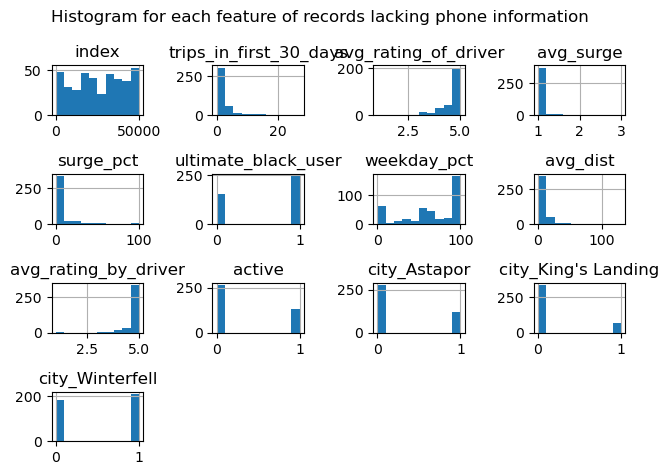

In [21]:
tr_missing_phone.hist()
plt.suptitle('Histogram for each feature of records lacking phone information')
plt.tight_layout()
plt.show()

In [22]:
temp_ult_df = transform_df(raw_ult_df)

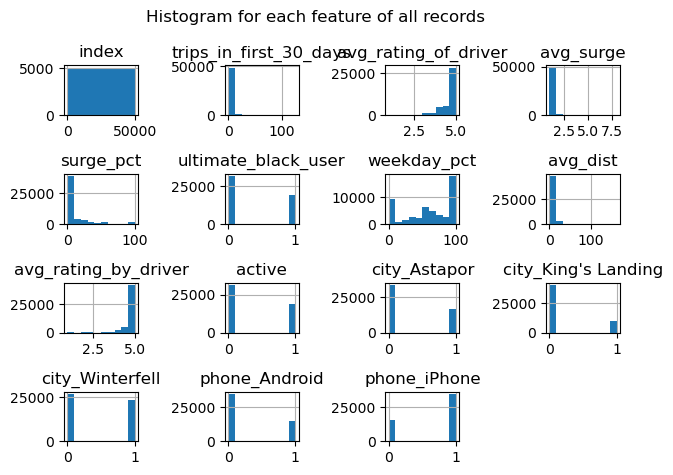

In [23]:
temp_ult_df.hist()
plt.suptitle('Histogram for each feature of all records')
plt.tight_layout()
plt.show()

I don't see any alarming disparities in the distributions of features in records lacking phone information versus those containing phone information. I'll just drop those rows since there are so few.

In [24]:
# Dropping records which lack phone information
dropped_phones_df = raw_ult_df.dropna(axis = 0, subset = ['phone'])
dropped_phones_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8026
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       198
dtype: int64

By dropping the records that didn't have phone information, I actually reduced the number of missing records in other columns as well. I'll look into whether I can drop the records that are missing avg_rating_by_driver as well, since it's such a small percentage of the dataset.

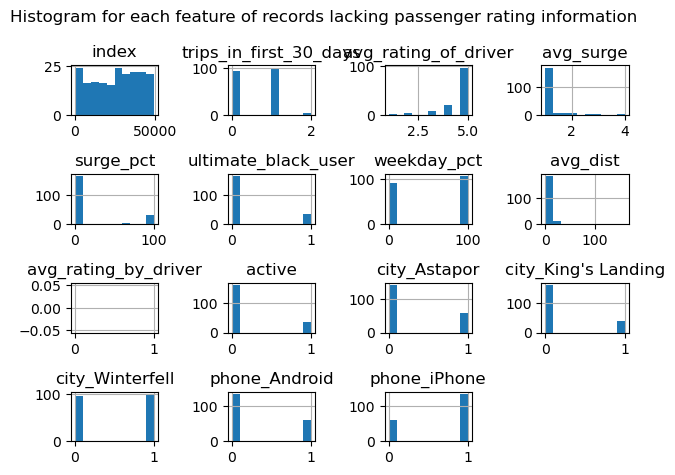

In [25]:
no_passenger_rating_df = transform_df(dropped_phones_df.loc[dropped_phones_df['avg_rating_by_driver'].isna()])
no_passenger_rating_df.hist()
plt.suptitle('Histogram for each feature of records lacking passenger rating information')
plt.tight_layout()
plt.show()

It doesn't appear I'll lose a meaningful subset of users by dropping these records either. These users likely just didn't receive a rating from a driver on their trips, which is more indicative of driver behavior. The last feature with lots of missing values is average rating given to the driver by the user. There are far more of these, so I don't want to drop those records.

In [26]:
drop_phone_pass_df = transform_df(raw_ult_df.dropna(axis = 0, subset = ['phone', 'avg_rating_by_driver']))
drop_phone_pass_df.isna().sum()

index                        0
trips_in_first_30_days       0
avg_rating_of_driver      7961
avg_surge                    0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
active                       0
city_Astapor                 0
city_King's Landing          0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
dtype: int64

There are just under 8,000 records left with no average driver rating feature. From experience, I know sometimes as a passenger, you skip the driver rating screen. I would guess that these riders have always skipped this screen. It isn't fair to equate this to a 0-star rating for the purposes of evaluating drivers, but may be an acceptable way of classifying this type of passenger for the purposes of predicting activity. I would assume that more frequent riders are more likely to understand the importance of rating drivers. I'll take a look and see how this group of users compares to the rest of the users and decide if I should fill the missing values with 0.

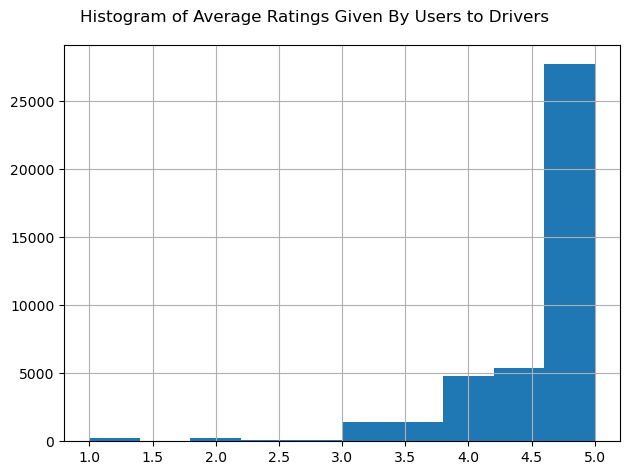

In [27]:
drop_phone_pass_df['avg_rating_of_driver'].hist()
plt.suptitle('Histogram of Average Ratings Given By Users to Drivers')
plt.tight_layout()
plt.show()

Right away, it's apparent that no users average a 0 rating for this feature. If I fill all missing values with 0, I capture the behavior without removing a ton of records. Perhaps it will be a useful feature - maybe users who don't rate drivers are less likely to be active on the platform.

In [28]:
# Dropping records missing the phone or average rating by driver. Imputing missing rating of driver with 0. 
# Dropping Android and Astapor to eliminate collinearity among dummies. Dropping avg_surge to avoid collinearity with surge_pct
ult_df = transform_df(raw_ult_df
                      .dropna(axis = 0, subset = ['phone', 'avg_rating_by_driver'])
                      .fillna(0)
                     ).drop(['phone_Android', 'city_Astapor', 'avg_surge'], axis = 1).reset_index()

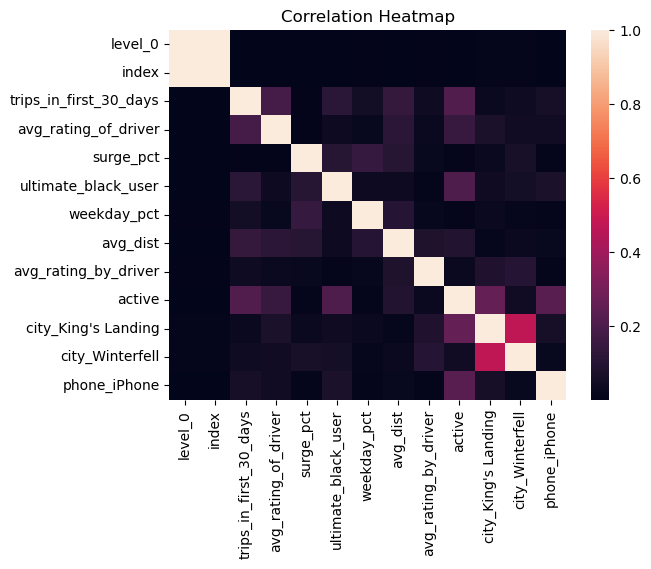

In [29]:
# Plotting the correlation heatmap
sns.heatmap(abs(ult_df.corr()))
plt.title('Correlation Heatmap')
plt.show()

We can see the 'Active' feature doesn't strongly correlate with any one feature in particular. There is a slight correlation between active status  the number of trips in the first 30 days, average rating of driver, ultimate_black usage, being from King's Landing, and owning an iPhone.

## EDA ##
Now that we have no missing values and can assert that there are no problematic collinear features, let's explore the dataset more.

In [30]:
ult_df.isna().sum()

level_0                   0
index                     0
trips_in_first_30_days    0
avg_rating_of_driver      0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active                    0
city_King's Landing       0
city_Winterfell           0
phone_iPhone              0
dtype: int64

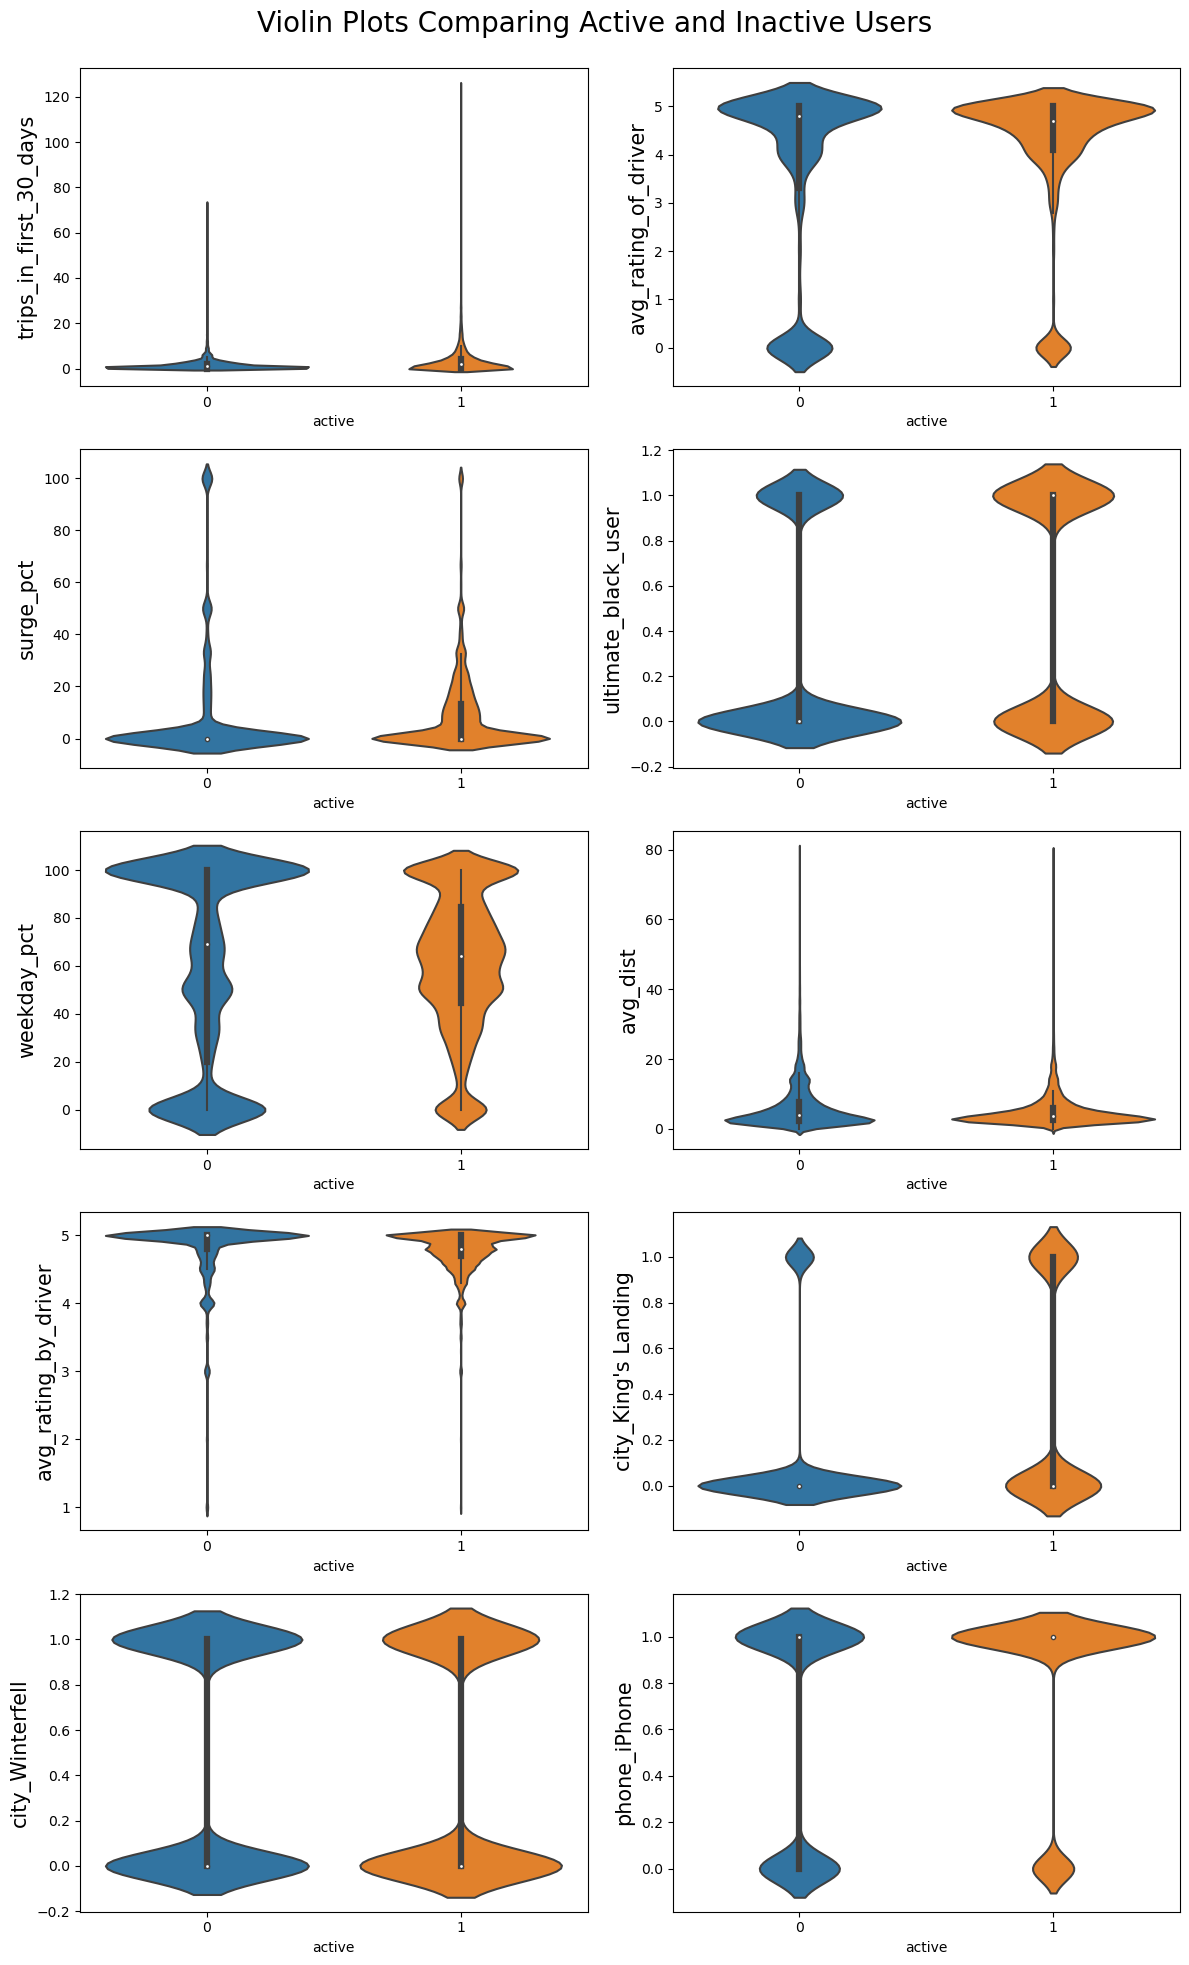

In [31]:
nrows = 5
ncols = 2
columns = ['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', "city_King's Landing",
       'city_Winterfell', 'phone_iPhone']

fig = plt.figure(figsize = (12, 20))
for i, col in enumerate(columns, 1):
    ax = fig.add_subplot(nrows, ncols, i)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(15)
    sns.violinplot(data = ult_df,
                    y = col,
                    x = 'active',
                    ax = ax,
                    whiskerprops={'color': 'lightgrey'},
                    medianprops = {'color': 'lightgrey'},
                    capprops = {'color': 'lightgrey'},
                    boxprops={'edgecolor': 'lightgrey'},
                    flierprops={'markerfacecolor': 'lightgrey', 'markeredgecolor': 'lightgrey'}
               )

fig.suptitle('Violin Plots Comparing Active and Inactive Users', fontsize = 20)
plt.tight_layout(rect = [0, 0 , 1 , .98])
plt.show()

The violin plots show us a couple potential trends. Having an iPhone seems to correlate more positively with being active. Active users also seem to use the app more consistently throughout the week versus just on the weekend.

## Preprocessing ##
Now that I understand the distribution of users and behaviors, I need to make sure I give the model the best data to work with.

### Scaling ###
The non-boolean columns will have to be scaled in order to be weighted more evenly with all the boolean columns.

In [32]:
# Selecting columns to scale

scale_cols = ['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']

unscaled_cols = ['ultimate_black_user', "city_King's Landing",
       'city_Winterfell', 'phone_iPhone', 'active']

In [33]:
# Applying the scaler to only non-boolean columns
scaler = StandardScaler()
scaled_ult_df = pd.DataFrame()
scaled_ult_df[scale_cols] = scaler.fit_transform(ult_df[scale_cols])
scaled_ult_df[unscaled_cols] = ult_df[unscaled_cols]

In [34]:
ult_df.count()

level_0                   49406
index                     49406
trips_in_first_30_days    49406
avg_rating_of_driver      49406
surge_pct                 49406
ultimate_black_user       49406
weekday_pct               49406
avg_dist                  49406
avg_rating_by_driver      49406
active                    49406
city_King's Landing       49406
city_Winterfell           49406
phone_iPhone              49406
dtype: int64

In [35]:
scaled_ult_df.isna().sum()

trips_in_first_30_days    0
avg_rating_of_driver      0
surge_pct                 0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
ultimate_black_user       0
city_King's Landing       0
city_Winterfell           0
phone_iPhone              0
active                    0
dtype: int64

In [36]:
scaled_ult_df['active'].value_counts()

0    30771
1    18635
Name: active, dtype: int64

In [37]:
# Verifying the scaling centered the data at 0 with unit variance
scaled_ult_df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

trips_in_first_30_days avg_rating_of_driver surge_pct weekday_pct  \
count               49406.00             49406.00  49406.00    49406.00   
mean                   -0.00                 0.00     -0.00       -0.00   
std                     1.00                 1.00      1.00        1.00   
min                    -0.60                -2.16     -0.44       -1.65   
25%                    -0.60                 0.08     -0.44       -0.75   
50%                    -0.34                 0.47     -0.44        0.16   
75%                     0.19                 0.64     -0.01        1.06   
max                    32.30                 0.64      4.58        1.06   

       avg_dist avg_rating_by_driver ultimate_black_user city_King's Landing  \
count  49406.00             49406.00            49406.00            49406.00   
mean       0.00                 0.00                0.38                0.20   
std        1.00                 1.00                0.48                0.40   
min       -1.03                -8.45                0.00                0.00   
25%       -0.60                -0.17                0.00                0.00   
50%       -0.34                 0.50                0.00                0.00   
75%        0.20                 0.50                1.00                0.00   
max       13.13                 0.50                1.00                1.00   

      city_Winterfell phone_iPhone    active  
count        49406.00     49406.00  49406.00  
mean             0.47         0.70      0.38  
std              0.50         0.46      0.48  
min              0.00         0.00      0.00  
25%              0.00         0.00      0.00  
50%              0.00         1.00      0.00  
75%              1.00         1.00      1.00  
max              1.00         1.00      1.00

### Separate X and y ###

In [38]:
X = scaled_ult_df.copy().drop(['active'], axis = 1)
y = scaled_ult_df['active'].copy()

### PCA ###
I want to see if PCA can explain most of the variance in the dataset while simplifying the model input.

In [39]:
pca = PCA()

pca.fit(X)

PCA()

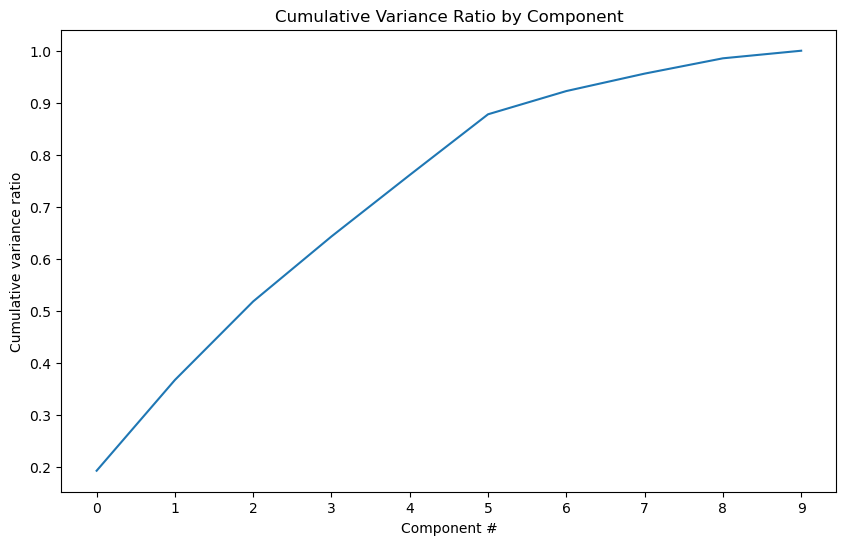

In [40]:
# Visualizing the explained variance
plt.subplots(figsize = (10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.xticks(np.arange(0, 10))
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative Variance Ratio by Component')
plt.show()

### PCA Evaluation ###
The first couple of principal components don't explain enough of the variance to make a PCA approach worthwhile on this dataset. It's more important to have all of the features.

## Model Selection ##
This scenario calls for a binary classifier model, of which scikit-learn has plenty. I want to check which models perform best on the data without any tuning and then I'll tune some of the better models. I also have a slight class imbalance so I have to stratify the train-test split.

In [41]:
# Train-test split, stratify y to ensure good representation of positive and negative classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14, stratify = y)

In [42]:
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('AdaBoost', AdaBoostClassifier())
]

In [43]:
cv_scores = {}

# Perform cross-validation and store results
for name, classifier in classifiers:
    pipeline = Pipeline([('classifier', classifier)])
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()
    cv_scores[name] = score

# Print the cross-validation scores
for name, score in cv_scores.items():
    print(f'{name}: {score:.4f}')

# Select the best model based on the cross-validation scores
best_model_name = max(cv_scores, key=cv_scores.get)
print(f'Best Model: {best_model_name}')

Logistic Regression: 0.5749
Random Forest: 0.6647
Gradient Boosting: 0.6969
SVM: 0.6577
AdaBoost: 0.6848
Best Model: Gradient Boosting


### Narrowing Models ###
AdaBoost and Gradient Boosting had the best performance. SVM was close, too. I want to try tuning the AdaBoost and Gradient Boost models to see if there are any performance improvements to be found with better parameters.

#### AdaBoost ####

In [44]:
# Define parameter grid
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
    # Ruled out SAMME earlier
    'algorithm': ['SAMME.R'],
    # Ruled out more extreme n_estimators
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.5, 1],
    'random_state': [14]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=AdaBoostClassifier(), 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=5,
                           n_jobs=-1,
                           verbose=1,
                          )

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.5, 'n_estimators': 200, 'random_state': 14}
Best Score: 0.7008565314966898


#### Gradient Boosting ####

In [45]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    # Ruled out other learning rates earlier
    'learning_rate': [0.1],
    'max_depth': [4, 5, 7],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'warm_start': [True, False],
    'random_state': [14]
}

# Setup the Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring = 'f1',
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('Best Parameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 14, 'warm_start': True}
Best Score: 0.7043098130292585


#### Stacking Classifier ####
After a couple rounds of adjusting parameter options for each, the gradient boosting model very slightly outperformed the AdaBoost model. Now I want to try stacking both classifiers.

In [46]:
base_classifiers = [
    ('adaboost', AdaBoostClassifier(
        algorithm = 'SAMME.R',
        base_estimator = DecisionTreeClassifier(max_depth=2), 
        learning_rate = 0.5, 
        n_estimators = 200, 
        random_state = 14)
    ),
    ('gradient_boosting', GradientBoostingClassifier(
        learning_rate = 0.1, 
        max_depth = 5, 
        max_features = 'log2', 
        min_samples_leaf = 2, 
        min_samples_split = 3, 
        n_estimators = 300, 
        warm_start = True, 
        random_state = 14)
    )
]

# Define meta-classifier
meta_classifier = LogisticRegression(random_state = 14)

# Create the Stacking Classifier
stacking_clf = StackingClassifier(estimators = base_classifiers, final_estimator = meta_classifier)

# Fit the Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Predict and evaluate the model
predictions = stacking_clf.predict(X_test)
matrix = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

print(matrix)
print(report)

[[8056 1175]
 [1868 3723]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9231
           1       0.76      0.67      0.71      5591

    accuracy                           0.79     14822
   macro avg       0.79      0.77      0.78     14822
weighted avg       0.79      0.79      0.79     14822



## Model Evaluation ##
The stacking classifier performed better than either the gradient boost or AdaBoost on their own

#### Stacking Model Evaluation ####

In [47]:
stacking_clf.fit(X_train, y_train)

y_prob = stacking_clf.predict_proba(X_test)[:, 1]
y_pred = stacking_clf.predict(X_test)

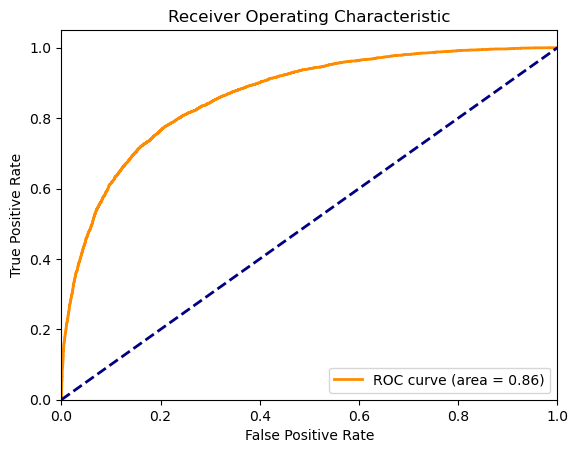

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(conf_matrix)
print(report)

[[8056 1175]
 [1868 3723]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9231
           1       0.76      0.67      0.71      5591

    accuracy                           0.79     14822
   macro avg       0.79      0.77      0.78     14822
weighted avg       0.79      0.79      0.79     14822



This model performed marginally better than the others, but has several drawbacks. The first is that it takes much longer to fit. The second is that we can't extract feature importances from it, meaning it's harder to use the model to inform decision making.

#### Gradient Boosting Evaluation ####
This model was very close in performance to the Stacking model.

In [50]:
model = GradientBoostingClassifier(
        learning_rate = 0.1, 
        max_depth = 5, 
        max_features = 'log2', 
        min_samples_leaf = 2, 
        min_samples_split = 3, 
        n_estimators = 300, 
        warm_start = True, 
        random_state = 14)

model.fit(X_train, y_train)

gb_y_prob = stacking_clf.predict_proba(X_test)[:, 1]
gb_y_pred = stacking_clf.predict(X_test)

In [51]:
gb_conf_matrix = confusion_matrix(y_test, gb_y_pred)
gb_report = classification_report(y_test, gb_y_pred)

print(gb_conf_matrix)
print(gb_report)

[[8056 1175]
 [1868 3723]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9231
           1       0.76      0.67      0.71      5591

    accuracy                           0.79     14822
   macro avg       0.79      0.77      0.78     14822
weighted avg       0.79      0.79      0.79     14822



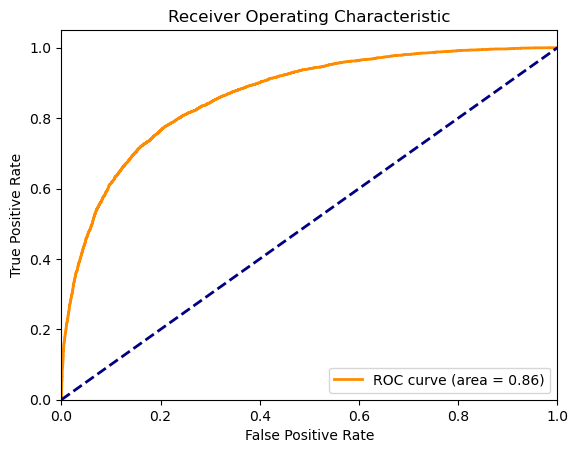

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, gb_y_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

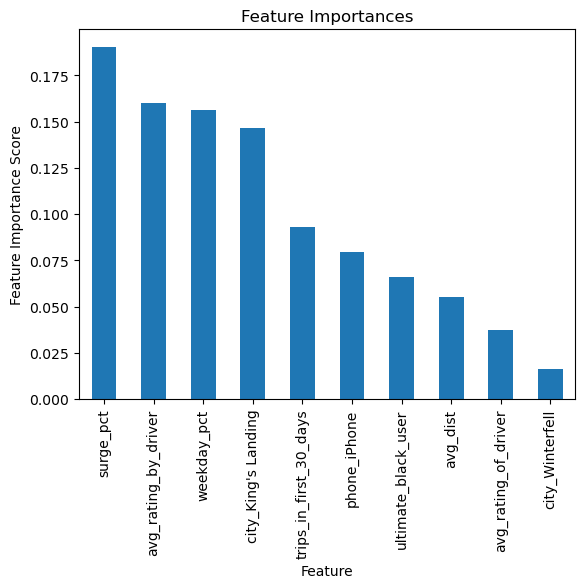

In [53]:
feat_imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')
plt.show()

While we lose a little bit of performance in terms of f1 score, we gain speed and computational efficiency. We also gain access to feature importances.

## Conclusion ##
### Model Selection ###
I chose the gradient boosting model. It performed near the 80% accuracy threshold, but more importantly it told us which attributes are most useful in accurately predicting active ridership. 

### Leveraging Insights ###
Surge percentage, average rating by driver, weekday percentage, and being from King's Landing were the most important predictors. Some of the features are purely explanatory but others offer great insights into opportunities to increase ridership and retention.

Surge pricing occurs when there is high demand and low supply of Ultimate drivers. This often occurs after large events, on weekend nights in cities, and at busy airports. After inspection, there is a moderate positive correlation between active users and a higher surge percentage. It follows that active users tend to use Ultimate to get to and/or from events that are likely to incur surge pricing conditions. This is a good insight. Ultimate could study where and when surges tend to occur and boost their marketing efforts in those areas. For instance, increasing ad visibility for travelers at airports or for clubgoers in cities. It would be prudent to encourage these potential users to get in the habit of using Ultimate as their transportation for events. It may also pay dividends to offer reduced surge pricing to frequent riders.

Average Rating By Driver refers to the average driver's opinion of the user. It makes sense that frequent riders would understand the social contract of ridesharing and likely behave politely toward drivers. While it is important for ridesharing apps to incentivize good behavior from both parties, it is hard to make a logical leap that incentivizing good user behavior would also lead to increased usership. The negative case, where a rider receives a poor rating from a driver, makes more sense. Riders are far more likely to receive poor ratings for behavior which could also get them banned from the app. They'd also be more likely, with a low average rating, to have other drivers skip their ride requests. It is not in the interest of Ultimate to keep these users around, for the sake of also keeping drivers happy. Drivers do not want bad riders in their cars.

Weekday percentage is another helpful insight when we consider habit building. From inspecting the data, we see that there is a positive correlation between active users and increased weekday usage. There are a number of reasons for this. Doubtlessly, some people use Ultimate when traveling on business. Others who don't own cars may use it for errands or commuting to places that are underserved by public transit. Others may use it to avoid drinking and driving. In any of these cases, it is important for Ultimate to use marketing to expand people's perceptions of ride sharing. Ultimate wants potential users and inactive users to consider using Ultimate any time they have to make a transportation-related decision because it will be comfortable, private, clean, peaceful, affordable, and convenient. Getting more users to think of Ultimate for weekday purposes and not just a way home from the bars on the weekend will improve ridership across the board.

Finally, King's Landing had a moderate positive correlation with activity. It would be interesting to understand what factors contribute to increased usership in King's Landing. Perhaps the area has poor public transit, or a busy events center or airport. In any case, Ultimate needs to understand if it should:
* Advertise more in King's Landing because there are some conditions that encourage activity among users from King's Landing 
* Or, treat King's Landing as a model city and explore how to create those conditions in other cities to usership in those places